In [1]:
# encoder test
# v1 : previous code 참조
# v2 : pre trained model 활용

In [2]:
import torch
import torch.nn as nn


import torchvision.models as models
from torchvision.models import (
#                                 mobilenet_v2, # --> not in torchvision v0.2.1
                                  resnet18, resnet34, resnet50, resnet101, resnet152
#                                 resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, 
#                                 wide_resnet50_2, wide_resnet101_2,
#                                 densenet161
                                )
from typing import Tuple

from torch.nn import functional as f
default_backbone = resnet18

In [3]:
def trim_network_at_index(network: nn.Module, index: int = -1) -> nn.Module:
    """
    Returns a new network with all layers up to index from the back.
    :param network: Module to trim.
    :param index: Where to trim the network. Counted from the last layer.
    """
    assert index < 0, f"Param index must be negative. Received {index}."
    return nn.Sequential(*list(network.children())[:index])

def calculate_backbone_feature_dim(backbone, input_shape: Tuple[int, int, int]) -> int:
    """ Helper to calculate the shape of the fully-connected regression layer. """
    tensor = torch.ones(1, *input_shape)
    output_feat = backbone.forward(tensor)
    return output_feat.shape[-1]

In [4]:
RESNET_VERSION_TO_MODEL = {'resnet18': resnet18, 'resnet34': resnet34,
                          'resnet50': resnet50, 'resnet101': resnet101,
                          'resnet152': resnet152}

In [5]:
# class MobileNetBackbone(nn.Module):
#     """
#     Outputs tensor after last convolution before the fully connected layer.
#     Allowed versions: mobilenet_v2.
#     """
#     def __init__(self, version: str):
#         """
#         Inits MobileNetBackbone.
#         :param version: mobilenet version to use.
#         """
#         super().__init__()

#         if version != 'mobilenet_v2':
#             raise NotImplementedError(f'Only mobilenet_v2 has been implemented. Received {version}.')

#         self.backbone = trim_network_at_index(mobilenet_v2(), -1)


#     def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
#         """
#         Outputs features after last convolution.
#         :param input_tensor:  Shape [batch_size, n_channels, length, width].
#         :return: Tensor of shape [batch_size, n_convolution_filters]. For mobilenet_v2,
#             the shape is [batch_size, 1280].
#         """
#         backbone_features = self.backbone(input_tensor)
#         return backbone_features.mean([2, 3])

In [6]:
class ResNetBackbone(nn.Module):
    """
    Outputs tensor after last convolution before the fully connected layer.


    Allowed versions: resnet18, resnet34, resnet50, resnet101, resnet152.
    """


    def __init__(self, version: str):
        """
        Inits ResNetBackbone
        :param version: resnet version to use.
        """
        super().__init__()


        if version not in RESNET_VERSION_TO_MODEL:
            raise ValueError(f'Parameter version must be one of {list(RESNET_VERSION_TO_MODEL.keys())}'
                             f'. Received {version}.')


        self.backbone = trim_network_at_index(RESNET_VERSION_TO_MODEL[version](), -1)


    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        """
        Outputs features after last convolution.
        :param input_tensor:  Shape [batch_size, n_channels, length, width].
        :return: Tensor of shape [batch_size, n_convolution_filters]. For resnet50,
            the shape is [batch_size, 2048].
        """
        backbone_features = self.backbone(input_tensor)
        return torch.flatten(backbone_features, start_dim=1)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


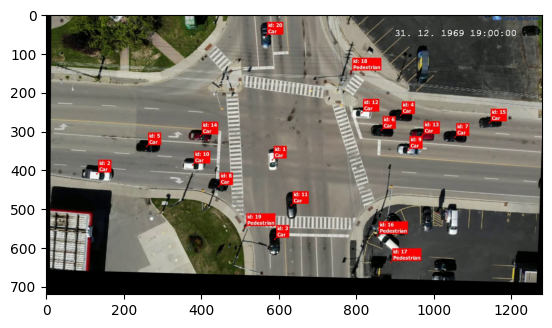

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
# 1. Load the image with Pillow library
img = Image.open('f0.jpg')
print(type(img))
plt.imshow(img)

In [11]:
import torchvision.transforms as transforms
to_tensor = transforms.ToTensor()
from torch.autograd import Variable

img_tensor = Variable((to_tensor(img)).unsqueeze(0))
print(img_tensor.dtype)
print(img_tensor.shape)
print(img_tensor)

torch.float32
torch.Size([1, 3, 720, 1280])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2314, 0.2314, 0.2196],
          [0.0000, 0.0000, 0.0000,  ..., 0.2314, 0.2235, 0.2118],
          [0.0000, 0.0000, 0.0000,  ..., 0.2353, 0.2275, 0.2196],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3412, 0.3333, 0.3216],
          [0.0000, 0.0000, 0.0000,  ..., 0.3294, 0.3216, 0.3137],
          [0.0000, 0.0000, 0.0000,  ..., 0.3255, 0.3176, 0.3059],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1020, 0.0863, 0.0667],
          [0.0000, 0.0000, 0.0000,  ..., 0.1020, 0.0941, 0.0745]

In [9]:
backbone_r1 = ResNetBackbone('resnet18')

In [10]:
f_vector1=backbone_r1(img_tensor)
print(f_vector1)
print(f_vector1.dtype)
print(f_vector1.shape)

tensor([[1.0697, 1.1274, 1.1049,  ..., 0.9354, 0.9046, 0.9096]],
       grad_fn=<ReshapeAliasBackward0>)
torch.float32
torch.Size([1, 295936])


In [12]:
class ImageEncoder(nn.Module):
    def __init__(self, backbone: nn.Module = default_backbone, 
                 n_hidden_layers: int = 4096, 
                 input_shape: Tuple[int, int, int] = (3, 1280, 720)):
        """
        :param backbone: CNN Backbone to use.
        :param seconds: Number of seconds into the future to predict.
            Default for the challenge is 6.
        :param n_hidden_layers: Size of fully connected layer after the CNN
            backbone processes the image.
        :param input_shape: Shape of the input expected by the network.
            This is needed because the size of the fully connected layer after
            the backbone depends on the backbone and its version.

        """
        super().__init__() # Module 클래스 속성을 초기화 함
        self.backbone = backbone
        print(f"backbone: {self.backbone}")
        backbone_feature_dim = calculate_backbone_feature_dim(backbone, input_shape)
        print(f"backbone_feature_dim: {backbone_feature_dim}")
        self.fc1 = nn.Linear(backbone_feature_dim, n_hidden_layers)
        
    def forward(self, image_tensor: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.
        :param image_tensor: Tensor of images shape [batch_size, n_channels, length, width].

        :return: Tensor of dimension [batch_size, number_of_modes * number_of_predictions_per_mode + number_of_modes]
            storing the predicted trajectory and mode probabilities. Mode probabilities are normalized to sum
            to 1 during inference.
        """
        backbone_features = self.backbone(image_tensor)
        x = f.relu(self.fc1(backbone_features))
        return x
        

In [13]:
backbone_r1 = ResNetBackbone('resnet18')

In [14]:
img_enc = ImageEncoder(backbone_r1)

backbone: ResNetBackbone(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

<class 'PIL.JpegImagePlugin.JpegImageFile'>


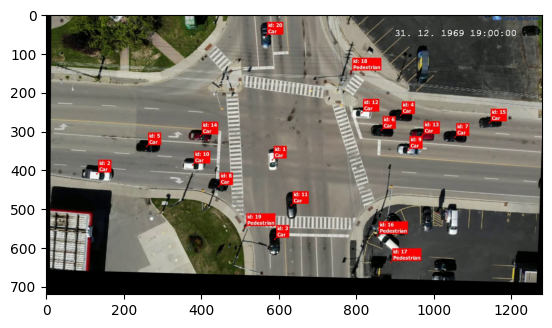

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
# 1. Load the image with Pillow library
img = Image.open('f0.jpg')
print(type(img))
plt.imshow(img)

In [17]:
# Image transforms
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
import torchvision.transforms as transforms
to_tensor = transforms.ToTensor()
from torch.autograd import Variable
# 2. Create a PyTorch Variable with the transformed image
t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
# t_img = Variable((to_tensor(img)).unsqueeze(0))
print(t_img.dtype)
print(t_img.shape)

torch.float32
torch.Size([1, 3, 224, 224])


C:\Users\NGN\AppData\Roaming\Python\Python37\site-packages\torchvision\transforms\transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [19]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding.numpy()

In [25]:
image_name = 'f0.jpg'
test = get_vector(image_name)
print(test)
print(type(test))
print(test.ndim)
print(test.shape)

[7.88812578e-01 5.50460517e-01 2.78585219e+00 4.89790678e-01
 1.56218123e+00 5.69541812e-01 9.91961598e-01 4.19058561e-01
 9.08636004e-02 2.94705486e+00 1.47371149e+00 5.02985299e-01
 1.69864863e-01 5.01809478e-01 9.42121446e-01 1.87572885e+00
 2.33083820e+00 1.11461616e+00 6.19832814e-01 1.26725304e+00
 1.25480568e+00 8.64488244e-01 2.74467182e+00 4.10221577e+00
 1.07455671e-01 9.42519546e-01 2.45156139e-01 7.03634739e-01
 3.79274003e-02 1.21655905e+00 6.04005516e-01 4.98847291e-03
 8.28606725e-01 9.69122767e-01 1.99908972e+00 1.66096103e+00
 1.21077335e+00 5.84608555e-01 3.32448751e-01 6.53836131e-01
 5.21388836e-02 4.32739049e-01 1.33312389e-01 9.63198841e-01
 3.44645441e-01 3.68218780e-01 1.27993956e-01 1.62564087e+00
 4.23371136e-01 7.30193079e-01 1.32554066e+00 3.18751335e+00
 3.67217374e+00 4.41491216e-01 2.18335247e+00 2.61781549e+00
 1.84853053e+00 1.09802812e-01 5.83262563e-01 2.82417655e-01
 4.03049767e-01 1.14548676e-01 4.57997262e-01 7.35189378e-01
 3.42120707e-01 5.342620